# Prepare Data

In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = 'glitchr'
os.environ["KAGGLE_KEY"] = '24bb8877ec6e7862d5d6a8cf2b52774b'

In [ ]:
!kaggle datasets download -d kneroma/tacotrashdataset
!unzip -qq tacotrashdataset.zip

100% 2.79G/2.79G [02:18<00:00, 24.3MB/s]
100% 2.79G/2.79G [02:18<00:00, 21.7MB/s]


In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Union,Tuple
from os.path import exists
import itertools as IT
import pickle as pkl
import numpy as np
import pandas as pd
import shutil
import json
import cv2
import os
DataPath = '/content/'

In [ ]:
!wget https://github.com/wimlds-trojmiasto/detect-waste/raw/main/annotations/annotations_train.json -N
# !wget https://github.com/wimlds-trojmiasto/detect-waste/raw/main/annotations/annotations_test.json -N

--2023-03-17 10:16:33--  https://github.com/wimlds-trojmiasto/detect-waste/raw/main/annotations/annotations_train.json
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wimlds-trojmiasto/detect-waste/main/annotations/annotations_train.json [following]
--2023-03-17 10:16:33--  https://raw.githubusercontent.com/wimlds-trojmiasto/detect-waste/main/annotations/annotations_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4109258 (3.9M) [text/plain]
Saving to: ‘annotations_train.json’

annotations_train.j 100%[===================>]   3.92M  --.-KB/s    in 0.04s   

Last-modified header mis

In [ ]:
with open('annotations_train.json', 'r') as f:
    annot = json.loads(f.read())

In [ ]:
batch_anns = '/content/data/annotations.json'
# Read annotations
with open(batch_anns, 'r') as f:
    dataset_batch = json.loads(f.read())

# Taco 28 Supercategories to detect waste 7 supercategories

In [ ]:
categories = dataset_batch['categories']
anns = dataset_batch['annotations']
imgs = dataset_batch['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [ ]:
#@title taco_to_detectwaste
def taco_to_detectwaste(label):
    glass = ['Glass bottle','Broken glass','Glass jar']
    metals_and_plastics = ['Aluminium foil', "Clear plastic bottle","Other plastic bottle",
                         "Plastic bottle cap","Metal bottle cap","Aerosol","Drink can",
                         "Food can","Drink carton","Disposable plastic cup","Other plastic cup",
                         "Plastic lid","Metal lid","Single-use carrier bag","Polypropylene bag",
                         "Plastic Film","Six pack rings","Spread tub","Tupperware",
                         "Disposable food container","Other plastic container",
                         "Plastic glooves","Plastic utensils","Pop tab","Scrap metal",
                         "Plastic straw","Other plastic", "Plastic film", "Food Can"]
    
    non_recyclable = ["Aluminium blister pack","Carded blister pack",
                    "Meal carton","Pizza box","Cigarette","Paper cup",
                    "Meal carton","Foam cup","Glass cup","Wrapping paper",
                    "Magazine paper","Garbage bag","Plastified paper bag",
                    "Crisp packet","Other plastic wrapper","Foam food container",
                    "Rope","Shoe","Squeezable tube","Paper straw","Styrofoam piece", "Rope & strings", "Tissues"]
    
    other = ["Battery"]
    paper = ["Corrugated carton","Egg carton","Toilet tube","Other carton", "Normal paper", "Paper bag"]
    bio = ["Food waste"]
    unknown = ["Unlabeled litter"]

    if (label in glass):
            label="glass"
    elif (label in metals_and_plastics):
            label="metals_and_plastics"
    elif(label in non_recyclable):
            label="non-recyclable"
    elif(label in other):
            label="other"
    elif (label in paper):
            label="paper"
    elif(label in bio):
            label="bio"
    elif(label in unknown):
            label="unknown"
    else:
        print(label, "is non-taco label")
        label = "unknown"
    return label

#### Before Super categories

In [ ]:
list(set([o['supercategory'] for o in dataset_batch['categories']]))

['Can',
 'Plastic container',
 'Cup',
 'Plastic glooves',
 'Blister pack',
 'Unlabeled litter',
 'Bottle',
 'Other plastic',
 'Scrap metal',
 'Lid',
 'Plastic utensils',
 'Styrofoam piece',
 'Shoe',
 'Food waste',
 'Battery',
 'Paper',
 'Straw',
 'Aluminium foil',
 'Squeezable tube',
 'Cigarette',
 'Bottle cap',
 'Glass jar',
 'Paper bag',
 'Plastic bag & wrapper',
 'Pop tab',
 'Rope & strings',
 'Carton',
 'Broken glass']

In [ ]:
classes= [
'metals_and_plastics',
'other',
'bio',
'glass',
'unknown',
'non-recyclable',
'paper']
class_map = dict(zip(classes,range(len(classes))))
class_map

{'metals_and_plastics': 0,
 'other': 1,
 'bio': 2,
 'glass': 3,
 'unknown': 4,
 'non-recyclable': 5,
 'paper': 6}

In [ ]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detectwaste
# detectwaste_categories = dataset_batch['categories']
for ann in anns:
    cat_id = ann['category_id']
    cat_taco = categories[cat_id]['name']
    label = taco_to_detectwaste(cat_taco)
    dataset_batch['categories'][cat_id]['supercategory'] = label
    dataset_batch['categories'][cat_id]['id'] = class_map[label]
# As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
dataset_batch['categories'][35]['supercategory'] = taco_to_detectwaste("Plastified paper bag")
dataset_batch['categories'][:5]

[{'supercategory': 'metals_and_plastics', 'id': 0, 'name': 'Aluminium foil'},
 {'supercategory': 'other', 'id': 1, 'name': 'Battery'},
 {'supercategory': 'non-recyclable',
  'id': 5,
  'name': 'Aluminium blister pack'},
 {'supercategory': 'non-recyclable', 'id': 5, 'name': 'Carded blister pack'},
 {'supercategory': 'metals_and_plastics',
  'id': 0,
  'name': 'Other plastic bottle'}]

#### After Super Categories

In [ ]:
!rm -rf /content/tmp
!mkdir -p tmp/data 
save_base_path  = 'tmp/data/'

In [ ]:
# cats = [o['supercategory'] for o in dataset_batch['categories']]

# ordered_supercats = list(set(cats))
ordered_supercats = list(class_map.keys())

print(ordered_supercats)
categories = dataset_batch['categories']
print(len(ordered_supercats))

['metals_and_plastics', 'other', 'bio', 'glass', 'unknown', 'non-recyclable', 'paper']
7


#### Json to Txt File 

In [ ]:
%cd {DataPath}/

labels = []
for o in dataset_batch['annotations']:
    fname = dataset_batch['images'][o['image_id']]['file_name']
    fname = fname[:-3] + 'txt'
    fname = fname.replace('atch_', '').replace('/', '_')
    image_w = dataset_batch['images'][o['image_id']]['width']
    image_h = dataset_batch['images'][o['image_id']]['height']
    # Grab bbox info 
    bbox = o['bbox']
    top_x, top_y, width, height = bbox
    # Change x and y from topleft to center
    center_x = top_x + (width/2)
    center_y = top_y + (height/2)
    # Normalize bbox values
    center_x /= image_w
    center_y /= image_h
    width /= image_w
    height /= image_h

    # Grab the category or supercategory, comment out whichever you don't want. Make sure to update the config file to reflect the correct list of classes
    # cat_idx = o['category_id'] # 60 

    supercat_name = dataset_batch['categories'][o['category_id']]['supercategory']
    cat_idx = ordered_supercats.index(supercat_name)
    labels.append(cat_idx)
    # Put category and 4 bbox values on one line for Yolov5 compatibility
    bbox_line = '{} {} {} {} {}\n'.format(cat_idx, center_x, center_y, width, height)
    #     print(bbox_line)

    # Write the annotation files
    f = open(f'{save_base_path}/{fname}', 'a')
    f.write(bbox_line)
    f.close()

/content


In [ ]:
!ls /content/tmp/data | head

b10_000000.txt
b10_000001.txt
b10_000002.txt
b10_000003.txt
b10_000004.txt
b10_000005.txt
b10_000006.txt
b10_000007.txt
b10_000008.txt
b10_000009.txt


In [ ]:
print('No of Labels: ',len(np.unique(labels)),'Labels: ',np.unique(labels))

No of Labels:  7 Labels:  [0 1 2 3 4 5 6]


### Move Images file to Labels Directory

In [ ]:
batch_id = 1
while batch_id < 16:
  batchdir = os.listdir(f'data/batch_{batch_id}')
  [shutil.copy(f'data/batch_{batch_id}/{o}', f'{save_base_path}/b{batch_id}_{o}') for o in batchdir if o[-3:].lower() == 'jpg']
  batch_id += 1

In [ ]:
!ls /content/tmp/data | head

b10_000000.jpg
b10_000000.txt
b10_000001.jpg
b10_000001.txt
b10_000002.jpg
b10_000002.txt
b10_000003.jpg
b10_000003.txt
b10_000004.jpg
b10_000004.txt


In [ ]:
## Coverting JPG to jpg
for i in os.listdir("/content/tmp/data"):
        if i.endswith((".jpg",".JPG")):
            os.rename(os.path.join('/content/tmp/data',i),os.path.join('/content/tmp/data/',i.split('.')[0]+'.jpg'))

#### Train Test Split

In [ ]:
def Train_Test_Split(src = "/content/tmp/data",ratios = (0.8,0.1,0.1),output_path =f"{DataPath}/taco" ):
    
    idx  = [os.path.split(i)[1].split('.')[0] for i in os.listdir(src) if i.endswith('.txt')]
    try:
        shutil.rmtree(output_path)
    except:
        pass
    train_path = f"{output_path}/train"
    test_path = f"{output_path}/test"
    val_path = f"{output_path}/val"
    os.makedirs(train_path,exist_ok=True)
    os.makedirs(test_path,exist_ok=True)
    os.makedirs(val_path,exist_ok=True)

    temp_idx,test_idx = train_test_split(idx,test_size = ratios[1],random_state = 42,shuffle = True)
    train_idx,val_idx = train_test_split(temp_idx,test_size = ratios[2],random_state = 42,shuffle = True)

    for id in tqdm(idx):
        if id in train_idx:
            shutil.copy(os.path.join(src,f"{id}.jpg"),train_path)
            shutil.copy(os.path.join(src,f"{id}.txt"),train_path)
            
        elif id in test_idx:
            shutil.copy(os.path.join(src,f"{id}.jpg"),test_path)
            shutil.copy(os.path.join(src,f"{id}.txt"),test_path)
        elif id in val_idx:
            shutil.copy(os.path.join(src,f"{id}.jpg"),val_path)
            shutil.copy(os.path.join(src,f"{id}.txt"),val_path)

In [ ]:
Train_Test_Split()

  0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
!ls /content/taco

test  train  val


In [ ]:
#@title Data Augmentation for Trainset
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

lib_path = os.path.join(os.path.realpath("."), "data_aug")
sys.path.append(lib_path)

def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    
    cords = cords[:,:4]
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])
        
def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image
    
    Parameters
    ----------
    
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]


    return bbox


def rotate_im(image, angle):
    """Rotate the image.
    
    Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored
    black. 
    
    Parameters
    ----------
    
    image : numpy.ndarray
        numpy image
    
    angle : float
        angle by which the image is to be rotated
    
    Returns
    -------
    
    numpy.ndarray
        Rotated Image
    
    """
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

#    image = cv2.resize(image, (w,h))
    return image

def get_corners(bboxes):
    
    """Get corners of bounding boxes
    
    Parameters
    ----------
    
    bboxes: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`      
        
    """
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

def rotate_box(corners,angle,  cx, cy, h, w):
    
    """Rotate the bounding box.
    
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
        
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
        
    h : int 
        height of the image
        
    w : int 
        width of the image
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    """

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated


def get_enclosing_box(corners):
    """Get an enclosing box for ratated corners of a bounding box
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`  
    
    Returns 
    -------
    
    numpy.ndarray
        Numpy array containing enclosing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    """
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final


def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding
    
    Parameters
    ----------
    
    img : numpy.ndarray
        Image 
    
    inp_dim: tuple(int)
        shape of the reszied image
        
    Returns
    -------
    
    numpy.ndarray:
        Resized image
    
    '''

    inp_dim = (inp_dim, inp_dim)
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h))
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 0)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

class RandomHorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*

    Parameters
    ----------
    p: float
        The probability with which the image is flipped


    Returns
    -------

    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`

    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box

    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bboxes):
            img_center = np.array(img.shape[:2])[::-1]/2
            img_center = np.hstack((img_center, img_center))
            if random.random() < self.p:
                img = img[:, ::-1, :]
                bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

                box_w = abs(bboxes[:, 0] - bboxes[:, 2])

                bboxes[:, 0] -= box_w
                bboxes[:, 2] += box_w

            return img, bboxes


class HorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*

    Parameters
    ----------
    p: float
        The probability with which the image is flipped


    Returns
    -------

    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`

    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box

    """

    def __init__(self):
        pass

    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))

        img = img[:, ::-1, :]
        bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

        box_w = abs(bboxes[:, 0] - bboxes[:, 2])

        bboxes[:, 0] -= box_w
        bboxes[:, 2] += box_w

        return img, bboxes


class RandomScale(object):
    """Randomly scales an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    scale: float or tuple(float)
        if **float**, the image is scaled by a factor drawn 
        randomly from a range (1 - `scale` , 1 + `scale`). If **tuple**,
        the `scale` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Scaled image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, scale = 0.2, diff = False):
        self.scale = scale

        
        if type(self.scale) == tuple:
            assert len(self.scale) == 2, "Invalid range"
            assert self.scale[0] > -1, "Scale factor can't be less than -1"
            assert self.scale[1] > -1, "Scale factor can't be less than -1"
        else:
            assert self.scale > 0, "Please input a positive float"
            self.scale = (max(-1, -self.scale), self.scale)
        
        self.diff = diff

        

    def __call__(self, img, bboxes):
    
        
        #Chose a random digit to scale by 
        
        img_shape = img.shape
        
        if self.diff:
            scale_x = random.uniform(*self.scale)
            scale_y = random.uniform(*self.scale)
        else:
            scale_x = random.uniform(*self.scale)
            scale_y = scale_x
            
    
        
        resize_scale_x = 1 + scale_x
        resize_scale_y = 1 + scale_y
        
        img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)
        
        bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
        
        
        canvas = np.zeros(img_shape, dtype = np.uint8)
        
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])
        
        
        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]
        
        img = canvas
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)
    
    
        return img, bboxes


class Scale(object):
    """Scales the image    
        
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    
    Parameters
    ----------
    scale_x: float
        The factor by which the image is scaled horizontally
        
    scale_y: float
        The factor by which the image is scaled vertically
        
    Returns
    -------
    
    numpy.ndaaray
        Scaled image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, scale_x = 0.2, scale_y = 0.2):
        self.scale_x = scale_x
        self.scale_y = scale_y
        

    def __call__(self, img, bboxes):
    
        
        #Chose a random digit to scale by 
        
        img_shape = img.shape
        
        
        resize_scale_x = 1 + self.scale_x
        resize_scale_y = 1 + self.scale_y
        
        img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)
        
        bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
        
        
        canvas = np.zeros(img_shape, dtype = np.uint8)
        
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])
        
        
        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]
        
        img = canvas
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)

    
        return img, bboxes  
    

class RandomTranslate(object):
    """Randomly Translates the image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Translated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, translate = 0.2, diff = False):
        self.translate = translate
        
        if type(self.translate) == tuple:
            assert len(self.translate) == 2, "Invalid range"  
            assert self.translate[0] > 0 & self.translate[0] < 1
            assert self.translate[1] > 0 & self.translate[1] < 1


        else:
            assert self.translate > 0 and self.translate < 1
            self.translate = (-self.translate, self.translate)
            
            
        self.diff = diff

    def __call__(self, img, bboxes):        
        #Chose a random digit to scale by 
        img_shape = img.shape
        
        #translate the image
        
        #percentage of the dimension of the image to translate
        translate_factor_x = random.uniform(*self.translate)
        translate_factor_y = random.uniform(*self.translate)
        
        if not self.diff:
            translate_factor_y = translate_factor_x
            
        canvas = np.zeros(img_shape).astype(np.uint8)
    
    
        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        
        
        #change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]
    
        
        
    
        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        img = canvas
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        
    
        
    
        
        return img, bboxes
    

class Translate(object):
    """Randomly Translates the image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Translated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, translate_x = 0.2, translate_y = 0.2, diff = False):
        self.translate_x = translate_x
        self.translate_y = translate_y

        assert self.translate_x > 0 and self.translate_x < 1
        assert self.translate_y > 0 and self.translate_y < 1
 

    def __call__(self, img, bboxes):        
        #Chose a random digit to scale by 
        img_shape = img.shape
        
        #translate the image
        
        #percentage of the dimension of the image to translate
        translate_factor_x = self.translate_x
        translate_factor_y = self.translate_y
        
            
        canvas = np.zeros(img_shape).astype(np.uint8)

        
        #get the top-left corner co-ordinates of the shifted box 
        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        
        
        #change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]

        
        

        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        img = canvas
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        

        

        
        return img, bboxes
    
    
class RandomRotate(object):
    """Randomly rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float or tuple(float)
        if **float**, the image is rotated by a factor drawn 
        randomly from a range (-`angle`, `angle`). If **tuple**,
        the `angle` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle = 10):
        self.angle = angle
        
        if type(self.angle) == tuple:
            assert len(self.angle) == 2, "Invalid range"  
            
        else:
            self.angle = (-self.angle, self.angle)
            
    def __call__(self, img, bboxes):
    
        angle = random.uniform(*self.angle)
    
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
    
        img = rotate_im(img, angle)
    
        corners = get_corners(bboxes)
    
        corners = np.hstack((corners, bboxes[:,4:]))
    
    
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
    
        new_bbox = get_enclosing_box(corners)
    
    
        scale_factor_x = img.shape[1] / w
    
        scale_factor_y = img.shape[0] / h
    
        img = cv2.resize(img, (w,h))
    
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
    
        bboxes  = new_bbox
    
        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
    
        return img, bboxes

    
class Rotate(object):
    """Rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float
        The angle by which the image is to be rotated 
        
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle):
        self.angle = angle
        

    def __call__(self, img, bboxes):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
            
            
        """
        
        angle = self.angle
        print(self.angle)
        
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
        
        corners = get_corners(bboxes)
        
        corners = np.hstack((corners, bboxes[:,4:]))

        img = rotate_im(img, angle)
        
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
        
        
        
        
        new_bbox = get_enclosing_box(corners)
        
        
        scale_factor_x = img.shape[1] / w
        
        scale_factor_y = img.shape[0] / h
        
        img = cv2.resize(img, (w,h))
        
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
        
        
        bboxes  = new_bbox

        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
        
        return img, bboxes
        


class RandomShear(object):
    """Randomly shears an image in horizontal direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float or tuple(float)
        if **float**, the image is sheared horizontally by a factor drawn 
        randomly from a range (-`shear_factor`, `shear_factor`). If **tuple**,
        the `shear_factor` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
        if type(self.shear_factor) == tuple:
            assert len(self.shear_factor) == 2, "Invalid range for scaling factor"   
        else:
            self.shear_factor = (-self.shear_factor, self.shear_factor)
        
        shear_factor = random.uniform(*self.shear_factor)
        
    def __call__(self, img, bboxes):
    
        shear_factor = random.uniform(*self.shear_factor)
    
        w,h = img.shape[1], img.shape[0]
    
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)
    
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
    
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])
    
        bboxes[:,[0,2]] += ((bboxes[:,[1,3]]) * abs(shear_factor) ).astype(int) 
    
    
        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
    
        if shear_factor < 0:
        	img, bboxes = HorizontalFlip()(img, bboxes)
    
        img = cv2.resize(img, (w,h))
    
        scale_factor_x = nW / w
    
        bboxes[:,:4] /= [scale_factor_x, 1, scale_factor_x, 1] 
    
    
        return img, bboxes
        
class Shear(object):
    """Shears an image in horizontal direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float
        Factor by which the image is sheared in the x-direction
       
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
    
    def __call__(self, img, bboxes):
        
        shear_factor = self.shear_factor
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)

        
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
                
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])
        
        bboxes[:,[0,2]] += ((bboxes[:,[1,3]])*abs(shear_factor)).astype(int) 
        

        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
        
        if shear_factor < 0:
             img, bboxes = HorizontalFlip()(img, bboxes)
             
        
        return img, bboxes
    
class Resize(object):
    """Resize the image in accordance to `image_letter_box` function in darknet 
    
    The aspect ratio is maintained. The longer side is resized to the input 
    size of the network, while the remaining space on the shorter side is filled 
    with black color. **This should be the last transform**
    
    
    Parameters
    ----------
    inp_dim : tuple(int)
        tuple containing the size to which the image will be resized.
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, inp_dim):
        self.inp_dim = inp_dim
        
    def __call__(self, img, bboxes):
        w,h = img.shape[1], img.shape[0]
        img = letterbox_image(img, self.inp_dim)
    
    
        scale = min(self.inp_dim/h, self.inp_dim/w)
        bboxes[:,:4] *= (scale)
    
        new_w = scale*w
        new_h = scale*h
        inp_dim = self.inp_dim   
    
        del_h = (inp_dim - new_h)/2
        del_w = (inp_dim - new_w)/2
    
        add_matrix = np.array([[del_w, del_h, del_w, del_h]]).astype(int)
    
        bboxes[:,:4] += add_matrix
    
        img = img.astype(np.uint8)
    
        return img, bboxes 
    

class RandomHSV(object):
    """HSV Transform to vary hue saturation and brightness
    
    Hue has a range of 0-179
    Saturation and Brightness have a range of 0-255. 
    Chose the amount you want to change thhe above quantities accordingly. 
    
    
    
    
    Parameters
    ----------
    hue : None or int or tuple (int)
        If None, the hue of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-hue, hue) and added to the 
        hue of the image. If tuple, the int is sampled from the range 
        specified by the tuple.   
        
    saturation : None or int or tuple(int)
        If None, the saturation of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-saturation, saturation) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
        
    brightness : None or int or tuple(int)
        If None, the brightness of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-brightness, brightness) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
    
    Returns
    -------
    
    numpy.ndaaray
        Transformed image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, hue = None, saturation = None, brightness = None):
        if hue:
            self.hue = hue 
        else:
            self.hue = 0
            
        if saturation:
            self.saturation = saturation 
        else:
            self.saturation = 0
            
        if brightness:
            self.brightness = brightness
        else:
            self.brightness = 0
            
            

        if type(self.hue) != tuple:
            self.hue = (-self.hue, self.hue)
            
        if type(self.saturation) != tuple:
            self.saturation = (-self.saturation, self.saturation)
        
        if type(brightness) != tuple:
            self.brightness = (-self.brightness, self.brightness)
    
    def __call__(self, img, bboxes):

        hue = random.randint(*self.hue)
        saturation = random.randint(*self.saturation)
        brightness = random.randint(*self.brightness)
        
        img = img.astype(int)
        
        a = np.array([hue, saturation, brightness]).astype(int)
        img += np.reshape(a, (1,1,3))
        
        img = np.clip(img, 0, 255)
        img[:,:,0] = np.clip(img[:,:,0],0, 179)
        
        img = img.astype(np.uint8)

        
        
        return img, bboxes
    
class Sequence(object):

    """Initialise Sequence object
    
    Apply a Sequence of transformations to the images/boxes.
    
    Parameters
    ----------
    augemnetations : list 
        List containing Transformation Objects in Sequence they are to be 
        applied
    
    probs : int or list 
        If **int**, the probability with which each of the transformation will 
        be applied. If **list**, the length must be equal to *augmentations*. 
        Each element of this list is the probability with which each 
        corresponding transformation is applied
    
    Returns
    -------
    
    Sequence
        Sequence Object 
        
    """
    def __init__(self, augmentations, probs = 1):

        
        self.augmentations = augmentations
        self.probs = probs
        
    def __call__(self, images, bboxes):
        for i, augmentation in enumerate(self.augmentations):
            if type(self.probs) == list:
                prob = self.probs[i]
            else:
                prob = self.probs
                
            if random.random() < prob:
                images, bboxes = augmentation(images, bboxes)
        return images, bboxes

def savefile(path,classes, filename, method, img, bboxes, dimensions):
    height = dimensions[0]
    width = dimensions[1]
    new_bboxes = []
    text = ''
    for box in bboxes:
        xc = (box[2] + box[0]) / (2 * width)
        yc = (box[3] + box[1]) / (2 * height)
        w = (box[2] - box[0]) / width
        h = (box[3] - box[1]) / height
        new_bboxes.append([xc, yc, w, h])
    
    for i in range(len(new_bboxes)):
        for j in range(4):
            if new_bboxes[i][j] > 1:
                new_bboxes[i][j] = 1
            elif new_bboxes[i][j] < 0:
                new_bboxes[i][j] = 0
    i = 0
    for box in new_bboxes:
        text += str(classes[i]) + ' '
        i += 1
        text += ' ' . join([str(x) for x in box]) + '\n'
    
    file = open(os.path.join(path,filename + '_' + method + '.txt') , 'w')
    file.write(text)
    file.close()

    cv2.imwrite(os.path.join(path,filename + '_' + method + '.jpg'), img)


def PrepareFolders():
    try:
        os.mkdir('sample/generated_labels')
        os.mkdir('sample/generated_images')
    except:
        ans = input('Destination folder is already exist, do you want to continue  (yes/no)')
        if(ans[0].lower() == 'n'):
            exit(0)

In [ ]:
#@title Augmentation
import pickle as pkl
from os.path import exists
from typing import Union,Tuple

class Augmentation:
    def  __init__(
        self,
        trainset_path:str,
        random_horizontal_flip:Union[float,None,bool] = 1,
        random_scale:Union[float,None,bool]  = 0.3,
        random_translate:Union[float,None,bool]  = 0.3,
        random_rotate:Union[float,None,bool]  = 20,
        random_shear:Union[float,None,bool]  = 0.2,
        random_HSV:Union[int,None,bool,tuple]  = (100,100,100),
        sequence:bool  = False,
        ):
        self.trainset_path = trainset_path
        
        self.RandomHorizontalFlip = random_horizontal_flip
        self.RandomScale = random_scale
        self.RandomTranslate = random_translate
        self.RandomRotate = random_rotate
        self.RandomShear = random_shear
        self.RandomHSV = random_HSV
        self.Sequence = sequence
        if self.trainset_path.endswith('/'):
            self.trainset_aug_path = self.trainset_path[:-1]+"_aug"
        else:
            self.trainset_aug_path = self.trainset_path+"_aug"
        try:
            shutil.rmtree(self.trainset_aug_path)
        except:
            print('Augmentation Folder Not Exists')
        os.makedirs(self.trainset_aug_path,exist_ok = True)
    def Create(self):

        files = [i for i in os.listdir(self.trainset_path) if not i.endswith(".txt")]
        for f in tqdm(files):
            
            filename = f.split('.')[0]
            extension = f.split('.')[1]
            img_name = os.path.join(self.trainset_path, filename+ "."+extension)
            txt_name = os.path.join(self.trainset_path,  filename+ ".txt")
            dest_img_name = os.path.join(self.trainset_aug_path, filename+ "."+extension)
            dest_txt_name = os.path.join(self.trainset_aug_path,  filename+ ".txt")
            shutil.copy(img_name,dest_img_name)
            shutil.copy(txt_name,dest_txt_name)

            img = cv2.imread(img_name) #[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
            # dimensions = img.shape
            
            # height, width, number of channels in image
            height = img.shape[0]
            width = img.shape[1]

            bboxes = []
            classes = []

            file = open(txt_name, 'r')
            lines = file.readlines()
            for line in lines:
                line = line[:-2]
                classes.append(line.split()[0])
                box = line.split()[1:]
                for i in range(len(box)):
                    box[i] = float(box[i])
                x1 = (float(box[0]) - float(box[2]) / 2) * width   
                x2 = (float(box[0]) + float(box[2]) / 2) * width
                y1 = (float(box[1]) - float(box[3]) / 2) * height
                y2 = (float(box[1]) + float(box[3]) / 2) * height
                box = [x1, y1, x2, y2]
                # print(box)
                bboxes.append(box)
            bboxes = np.array(bboxes)
            
            ##first
            if self.RandomHorizontalFlip not in( False ,None):
                img_, bboxes_ = RandomHorizontalFlip(self.RandomHorizontalFlip)(img.copy(), bboxes.copy())
                savefile(self.trainset_aug_path,classes, filename, "RandomHorizontalFlip", img_, bboxes_, img.shape)

            ###second
            if self.RandomScale not in( False ,None):
                img_, bboxes_ = RandomScale(self.RandomScale, diff = True)(img.copy(), bboxes.copy())
                savefile(self.trainset_aug_path,classes, filename, "RandomScale", img_, bboxes_, img.shape)

            ###third
            if self.RandomTranslate not in( False ,None):
                img_, bboxes_ = RandomTranslate(self.RandomTranslate, diff = True)(img.copy(), bboxes.copy())
                savefile(self.trainset_aug_path,classes, filename, "RandomTranslate", img_, bboxes_, img.shape)

            ###fourth
            if self.RandomRotate not in( False ,None):
                img_, bboxes_ = RandomRotate(self.RandomRotate)(img.copy(), bboxes.copy())
                savefile(self.trainset_aug_path,classes, filename, "RandomRotate", img_, bboxes_, img.shape)

            ###fifth
            if self.RandomShear not in( False ,None):
                img_, bboxes_ = RandomShear(self.RandomShear)(img.copy(), bboxes.copy())
                savefile(self.trainset_aug_path,classes, filename, "RandomShear", img_, bboxes_, img.shape)
            
            ###sixth
            if self.RandomHSV not in( False ,None):
                img_, bboxes_ = RandomHSV(self.RandomHSV[0], self.RandomHSV[1], self.RandomHSV[2])(img.copy(), bboxes.copy())
                savefile(self.trainset_aug_path,classes, filename, "RandomHSV", img_, bboxes_, img.shape)

            ##seventh
            if self.Sequence not in( False ,None):
                seq = Sequence([ 
                    RandomHSV(self.RandomHSV[0], self.RandomHSV[1], self.RandomHSV[2]),
                    RandomHorizontalFlip(self.RandomHorizontalFlip),
                    RandomScale(self.RandomScale, diff = True),
                    RandomTranslate(self.RandomTranslate, diff = True),
                    RandomRotate(self.RandomRotate),
                    RandomShear(self.RandomShear)
                    ])
                img_, bboxes_ = seq(img.copy(), bboxes.copy())
                savefile(self.trainset_aug_path,classes, filename, "Sequence", img_, bboxes_, img.shape)


#### sample_aug

In [ ]:
#@title
def plot_one_box(x, image, color=None, label=True, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    # cv2.rectangle(image, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(image, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(image, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
def plot(ax,img_path = '/content/train_aug/b12_000057.jpg',txt_path = '/content/train_aug/b12_000057_RandomHSV.txt'):
    try:
        name = img_path.split('_')[-1].split('.')[0]
    except:
        name = img_path.split('/')[-1].split('.')[0]
    img = cv2.imread(img_path)
    dh, dw, _ = img.shape
    ax.set_title(name,fontsize = 24)
    fl = open(txt_path, 'r')
    data = fl.readlines()
    fl.close()
    tl = round(0.002 * (dh + dw) / 2) + 1  # line/font thickness
    for dt in data:

        # Split string to float
        _, x, y, w, h = map(float, dt.split(' '))
        # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
        # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)
        
        if l < 0:
            l = 0
        if r > dw - 1:
            r = dw - 1
        if t < 0:
            t = 0
        if b > dh - 1:
            b = dh - 1
        # tf = max(tl - 1, 1) 
        tf = 18
        img = cv2.rectangle(img, (l, t), (r, b), (255, 0, 255), 25)
        cv2.putText(img, ordered_supercats[int(_)]+str(int(_)), (l, t- 2), 0, tl, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    ax.imshow(img)

In [ ]:
os.makedirs("/content/train",exist_ok = True)
ids = [ i.split('.')[0] for i in os.listdir('/content/taco/train') if i.endswith('.txt')][:5]
for i in range(5):
    shutil.copy("/content/taco/train/"+ids[i]+".jpg","/content/train")
    shutil.copy("/content/taco/train/"+ids[i]+".txt","/content/train")


In [ ]:
aug = Augmentation(
    '/content/train/',
    random_horizontal_flip = 1,
    random_scale  = False,
    random_translate = 0.3,
    random_rotate = 20,
    random_shear =False,
    random_HSV  = False, # (100,100,100) Three values between [0-255]
    
    )
aug.Create()

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
idxs = os.listdir('/content/train_aug')[0].split('.')[0]
idxs

'b12_000052'

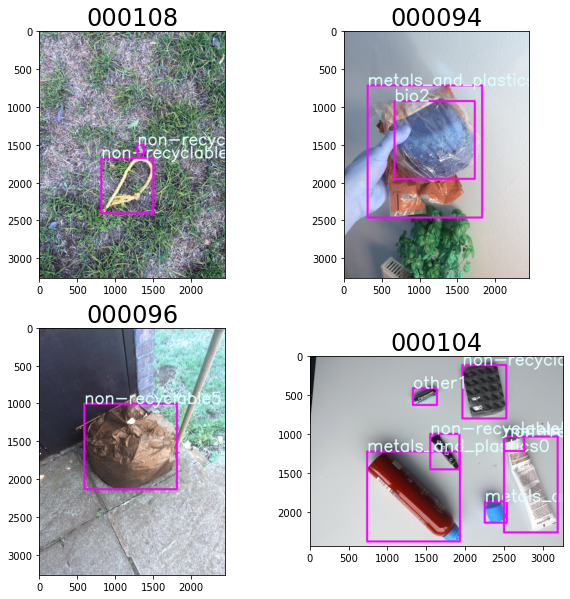

In [ ]:
fig,axes = plt.subplots(2,2,figsize = (10,10))
axes = axes.flatten()
plot_path = "/content/tmp/data"
# ids = [i.split('.')[0] for i in os.listdir(plot_path) if i.split('.')[0] in ['b1_000108','b1_000094']][:2]
ids = ['b1_000108', 'b1_000094','b1_000096','b1_000104']
for id,ax in enumerate(axes):
    plot(ax,f'{plot_path}/{ids[id]}.jpg',f'{plot_path}/{ids[id]}.txt')
plt.show()

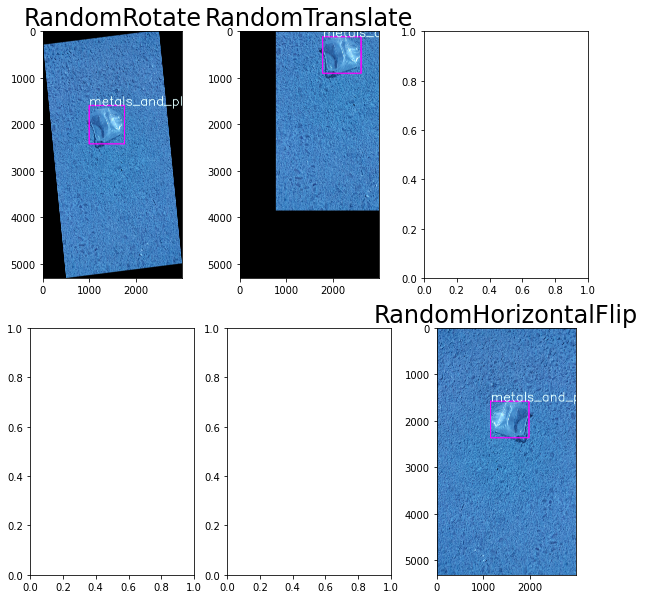

In [ ]:
fig,axes = plt.subplots(2,3,figsize = (10,10))
axes = axes.flatten()
plot(axes[0],f'/content/train_aug/{idxs}_RandomRotate.jpg',f'/content/train_aug/{idxs}_RandomRotate.txt')
plot(axes[1],f'/content/train_aug/{idxs}_RandomTranslate.jpg',f'/content/train_aug/{idxs}_RandomTranslate.txt')
# plot(axes[2],f'/content/train_aug/{idxs}_RandomHSV.jpg',f'/content/train_aug/{idxs}_RandomHSV.txt')
# plot(axes[3],f'/content/train_aug/{idxs}_RandomShear.jpg',f'/content/train_aug/{idxs}_RandomShear.txt')
# plot(axes[4],f'/content/train_aug/{idxs}_RandomScale.jpg',f'/content/train_aug/{idxs}_RandomScale.txt')
plot(axes[5],f'/content/train_aug/{idxs}_RandomHorizontalFlip.jpg',f'/content/train_aug/{idxs}_RandomHorizontalFlip.txt')
plt.show()

In [ ]:
#Just add RandomRotate, RandomHorizontalFlip, RandomScale
aug = Augmentation(
    '/content/taco/train',
    random_horizontal_flip = 1,
    random_scale  = False,
    random_translate = 0.3,
    random_rotate = 20,
    random_shear =False,
    random_HSV  = False, # (100,100,100) Three values between [0-255]
)
aug.Create()

Augmentation Folder Not Exists


  0%|          | 0/1215 [00:00<?, ?it/s]

<ipython-input-24-5d2b2bf0e6de>:89: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)
<ipython-input-24-5d2b2bf0e6de>:89: RuntimeWarning: divide by zero encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)


In [ ]:
datadir = '/content/taco'

#### Creating train_images.txt, valid and test file for images directory path

In [ ]:
%cd {datadir}/train_aug
import os
file = open("train_images.txt", "w") 
for filename in os.listdir(f'{datadir}/train_aug/'):
    # print("../train/images/" + filename)
    if filename == "train_images.txt":
        pass
    elif filename.endswith(".txt"):
        pass
    else:
        file.write(f"{datadir}/train_aug/" + filename + "\n")
file.close()


## Valid
%cd {datadir}/val
file = open("valid_images.txt", "w") 
for filename in os.listdir(f'{datadir}/val/'):
    # print("../train/images/" + filename)
    if filename == "valid_images.txt":
        pass
    elif filename.endswith(".txt"):
        pass
    else:
        file.write(f"{datadir}/val/" + filename + "\n")
file.close()


## Test
%cd {datadir}/test
# create Ultralytics specific text file of validation images
file = open("test_images.txt", "w") 
for filename in os.listdir(f'{datadir}/test/'):
    # print("../train/images/" + filename)
    if filename == "test_images.txt":
        pass
    elif filename.endswith(".txt"):
        pass
    else:
        file.write(f"{datadir}/test/" + filename + "\n")
file.close()

/content/taco/train_aug
/content/taco/val
/content/taco/test


## Install YoloV3-DarkNet

In [ ]:
%cd /content/

!git clone https://github.com/AlexeyAB/darknet
  
!apt-get update
!apt-get upgrade


!apt-get install build-essential
!apt-get install cmake git libgtk2.0-dev pkg-config libavcodec-dev libavformat-dev libswscale-dev

!apt-get install libavcodec-dev libavformat-dev libswscale-d

!apt-get install libopencv-dev

  
%cd darknet

!ls
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile


!ls
%cd ../
!ls


!apt install g++-5
!apt install gcc-5

!apt update
!apt upgrade

import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

print("'sup!'")

!/usr/local/cuda/bin/nvcc --version

%cd darknet
!wget https://pjreddie.com/media/files/yolov3.weights
!make

/content
Cloning into 'darknet'...
remote: Enumerating objects: 15514, done.
remote: Total 15514 (delta 0), reused 0 (delta 0), pack-reused 15514
Receiving objects: 100% (15514/15514), 14.17 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (10412/10412), done.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [920 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,544 kB]
Hit:10 http://

In [ ]:
%cd /content/

/content


#### Changes in config(/content/darknet/backup/detect_waste.cfg) files:
``` python
################
8 batch=64
9 subdivisions=16

#################
21 burn_in=1000
22 max_batches = 500
23 policy=steps
24 steps=40,45
```

filters = (num_class+5)*3

    filter: (7+5)*3 = 36
``` python
#################
605 filters=36
612 classes = 7

691 filters=36
698 classes=7

778 filters=36
785 classes=7
#################
```

In [ ]:
#@title Configs
%%writefile /content/darknet/backup/detect_waste.cfg
[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 50
policy=steps
steps=40,45
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=256
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=512
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

######################

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=36
activation=linear


[yolo]
mask = 6,7,8
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
classes=7
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1


[route]
layers = -4

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 61



[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=36
activation=linear


[yolo]
mask = 3,4,5
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
classes=7
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1



[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 36



[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=36
activation=linear


[yolo]
mask = 0,1,2
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
classes=7
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1



Writing /content/darknet/backup/detect_waste.cfg


In [ ]:
print('\n'.join(ordered_supercats))

metals_and_plastics
other
bio
glass
unknown
non-recyclable
paper


In [ ]:
%%writefile {datadir}/train/data.names
metals_and_plastics
other
bio
glass
unknown
non-recyclable
paper

Writing /content/taco/train/data.names


In [ ]:
%%writefile {datadir}/train/trainer.data
classes=7
train=/content/taco/train_aug/train_images.txt
valid=/content/taco/val/valid_images.txt
names = /content/taco/train/data.names
backup = /content/darknet/backup

Writing /content/taco/train/trainer.data


In [ ]:
%cat /content/taco/train_aug/train_images.txt | head

/content/taco/train_aug/b8_000054_RandomHorizontalFlip.jpg
/content/taco/train_aug/b14_000074_RandomRotate.jpg
/content/taco/train_aug/b11_000014_RandomRotate.jpg
/content/taco/train_aug/b12_000014_RandomRotate.jpg
/content/taco/train_aug/b15_000073.jpg
/content/taco/train_aug/b7_000088.jpg
/content/taco/train_aug/b1_000043_RandomRotate.jpg
/content/taco/train_aug/b14_000015_RandomTranslate.jpg
/content/taco/train_aug/b3_IMG_4965.jpg
/content/taco/train_aug/b3_IMG_5045_RandomTranslate.jpg


In [ ]:
%cat {datadir}/train/trainer.data

classes=7
train=/content/taco/train_aug/train_images.txt
valid=/content/taco/val/valid_images.txt
names = /content/taco/train/data.names
backup = /content/darknet/backup


# Train Model

In [ ]:
!ls /content/darknet

3rdparty		darknet_video.py       README.md
backup			data		       results
build			image_yolov3.sh        scripts
build.ps1		image_yolov4.sh        src
cfg			include		       vcpkg.json
cmake			json_mjpeg_streams.sh  vcpkg.json.opencv23
CMakeLists.txt		LICENSE		       video_yolov3.sh
darknet			Makefile	       video_yolov4.sh
DarknetConfig.cmake.in	net_cam_v3.sh	       yolov3.weights
darknet_images.py	net_cam_v4.sh
darknet.py		obj


In [ ]:
# Start a new training
%cd /content/darknet
!./darknet detector train {datadir}/train/trainer.data /content/darknet/backup/detect_waste.cfg ./yolov3.weights -dont_show -clear 
%cd /content/

/content/darknet
 CUDA-version: 11080 (12000), GPU count: 1  
 OpenCV version: 4.2.0
detect_waste
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0,

In [ ]:
from PIL import Image

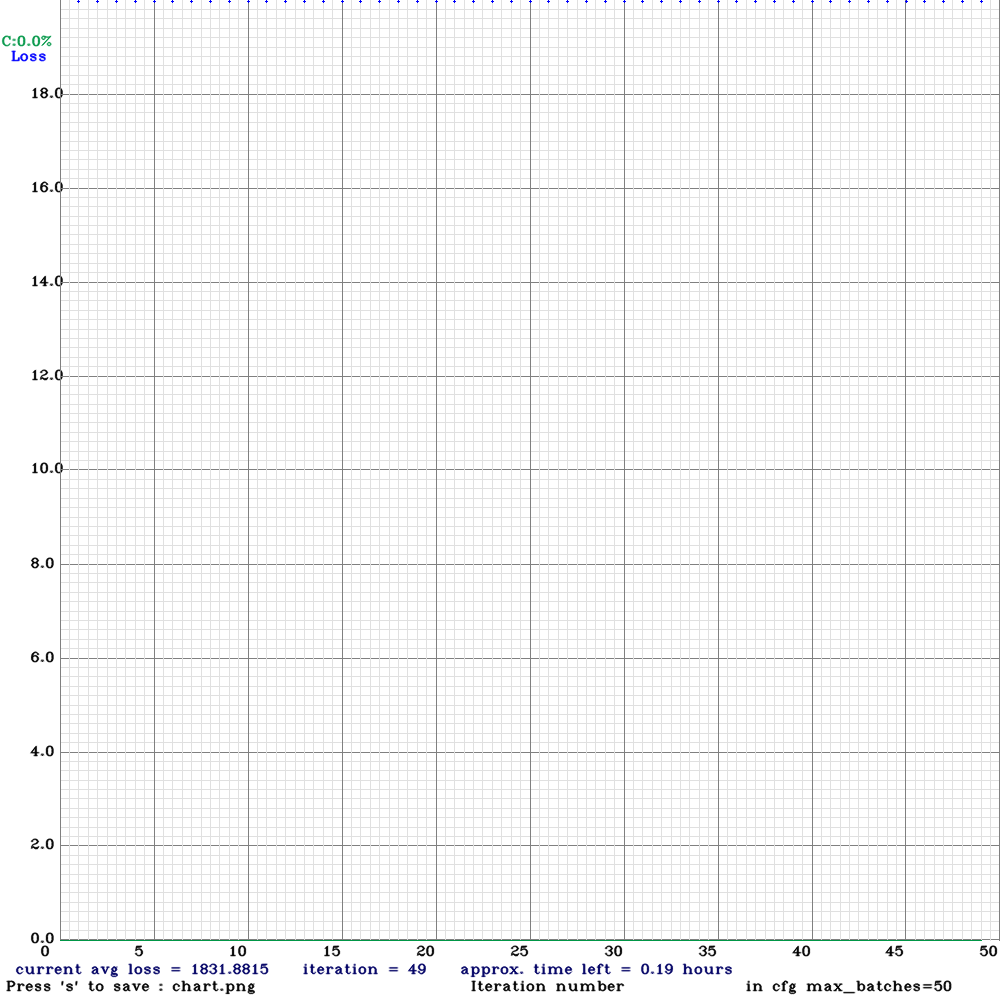

In [ ]:
Image.open("/content/darknet/chart.png")

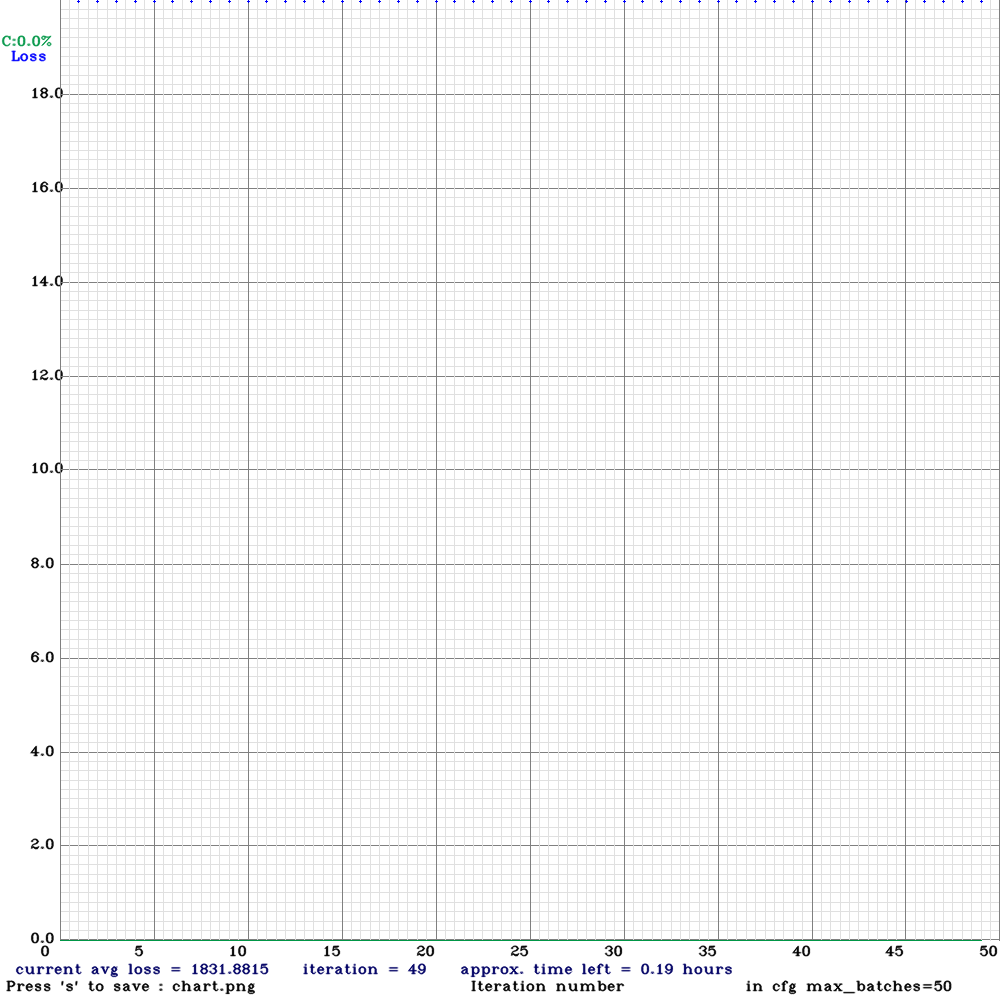

In [ ]:
Image.open("/content/darknet/chart_detect_waste.png")


# Inference


In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()


/content/darknet
 CUDA-version: 11080 (12000), GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outp

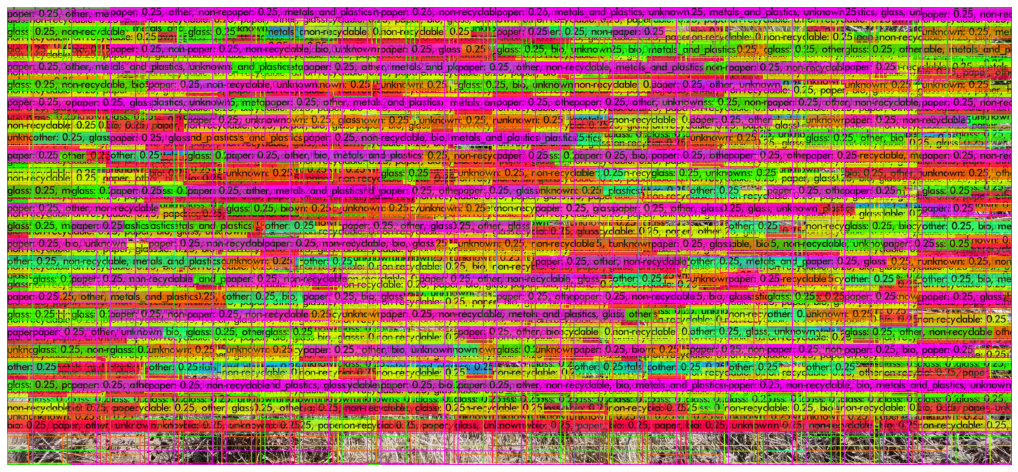

/content


In [ ]:
%cd /content/darknet
!.//darknet detector test {datadir}/train/trainer.data /content/darknet/backup/detect_waste.cfg ./backup/detect_waste_final.weights /content/taco/test/b10_000009.jpg #-dont_show -clear 
imShow('predictions.jpg')
%cd /content/

In [ ]:
!git clone https://github.com/cfotache/pytorch_objectdetecttrack.git

Cloning into 'pytorch_objectdetecttrack'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 36 (delta 5), reused 2 (delta 2), pack-reused 19
Unpacking objects: 100% (36/36), 2.88 MiB | 5.90 MiB/s, done.


In [ ]:
!pip install torchvision --q

In [ ]:
%cd /content/pytorch_objectdetecttrack
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
%cd /content/


/content/pytorch_objectdetecttrack
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp -r /content/darknet/backup/detect_waste_final.weights /content/drive/MyDrive

In [ ]:

config_path='/content/darknet/backup/detect_waste.cfg'
weights_path='/content/darknet/backup/detect_waste_final.weights'
class_path='/content/taco/train/data.names'
img_size=416
conf_thres=0.5
nms_thres=0.1


In [ ]:

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

In [ ]:
ids

['b1_000108', 'b1_000094', 'b1_000096', 'b1_000104']

Inference Time: 0:00:00.267712


<Figure size 432x288 with 0 Axes>

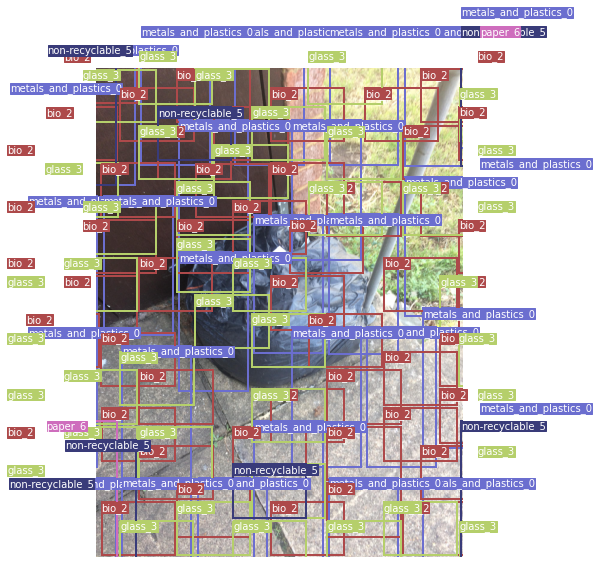

In [ ]:
# load image and get detections
img_path = "/content/tmp/data/b1_000096.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    detections = detections.detach().cpu().numpy()
    unique_labels = np.unique(detections[:, -1])
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)]+"_"+str(int(cls_pred)), color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

In [ ]:
detections